## Import libraries :

In [73]:
import nltk
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



In [4]:
# Download NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

##  1. choose a representative sample

In [5]:
import pandas as pd
#load data
url = "https://raw.githubusercontent.com/ironhack-labs/project-nlp-challenge/refs/heads/main/dataset/data.csv"
df = pd.read_csv(url)

df.head()

,label,title,text,subject,date
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,1,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,1,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,1,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [6]:
#check dataset size
rows, cols = df.shape
print(f"Dataset contains {rows} rows and {cols} columns.")

Dataset contains 39942 rows and 5 columns.


In [9]:
#drop unwanted columns
df = df.drop(columns=['date','subject','title'],axis=1)

In [10]:
#select 20% of the data
sample = df.sample(frac=0.2, random_state=42)
sample.head()

,label,text
6524,1,(This January 3 story was corrected to remove...
30902,0,So much for healthy debate on college campus I...
36459,0,The information is spilling out little by litt...
9801,1,WASHINGTON (Reuters) - U.S. Republican preside...
25638,0,"Attention, conservative men. This one is for y..."


In [11]:
sample.shape

(7988, 2)

## Text pre-processing

In [13]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [63]:
def preprocess_text(text):
  text = text.lower()  # Convert to lowercase
  text = re.sub(r'[^\w\s]', '', text) # # remove all the punctuation
  tokens = word_tokenize(text)  # Tokenization
  tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
  tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
  return ' '.join(tokens)



In [59]:
#TF-IDF
def Tfid_v(text):
    vectorizer_Tfidf = TfidfVectorizer(
        preprocessor=preprocess_text,
        ngram_range=(1,2),
        max_features=2500  # Keep only the 2500 most frequent words
    )

    tokens = vectorizer_Tfidf.fit_transform(text)
    features = vectorizer_Tfidf.get_feature_names_out()
    x_df = pd.DataFrame(tokens.toarray(), columns=features)

    return x_df, vectorizer_Tfidf  # Return features and trained vectorizer


 #CountVectorizer
def create_features(text):
    vectorizer = CountVectorizer(
        preprocessor=preprocess_text,
        ngram_range=(1,2),
        max_features=2500 # Keep only the 2500 most frequent words
    )
    tokens = vectorizer.fit_transform(text)
    features = vectorizer.get_feature_names_out()
    x_df = pd.DataFrame(tokens.toarray(), columns=features)
    return x_df, vectorizer

#apply
def apply_features(text, vectorizer):
    tokens = vectorizer.transform(text)
    features = vectorizer.get_feature_names_out()
    x_df = pd.DataFrame(tokens.toarray(), columns=features)
    return x_df




## spilt to train_test_split


In [15]:
#spilt to train_test_split
x_train, x_test, y_train, y_test = train_test_split(sample.text,sample.label, test_size=0.2, random_state=42)

In [31]:
# Encoding categorical target labels into numerical values
label_encoder = LabelEncoder()
y_encoded_train = label_encoder.fit_transform(y_train)
y_encoded_test = label_encoder.transform(y_test)

In [52]:
#CountVectorizer
# Extract features from training data and store the vectorizer
x_train_feat, vectorizer = create_features(x_train)

# Apply the same transformation to test data
x_test_feat = apply_features(x_test, vectorizer)

In [54]:
#TF-IDF
# Convert training data to TF-IDF features and store the vectorizer
x_train_Tfidf,  vectorizer_Tfidf = Tfid_v(x_train)

# Apply the same TF-IDF transformation to test data
x_test_Tfidf = apply_features(x_test,  vectorizer_Tfidf)

##  Logistic Regression model

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## Train a simple Logistic Regression model using CountVectorizer features
model = LogisticRegression(
    penalty='l2',
    solver='saga',
)
model.fit(x_train_feat, y_encoded_train)

predictions = model.predict(x_test_feat)
accuracy_s = accuracy_score(y_encoded_test, predictions)
print(f"Model Accuracy: {accuracy_s:.4f}")
print("Classification Report:\n", classification_report(y_encoded_test, predictions))

Model Accuracy: 0.9819
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       805
           1       0.98      0.99      0.98       793

    accuracy                           0.98      1598
   macro avg       0.98      0.98      0.98      1598
weighted avg       0.98      0.98      0.98      1598



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


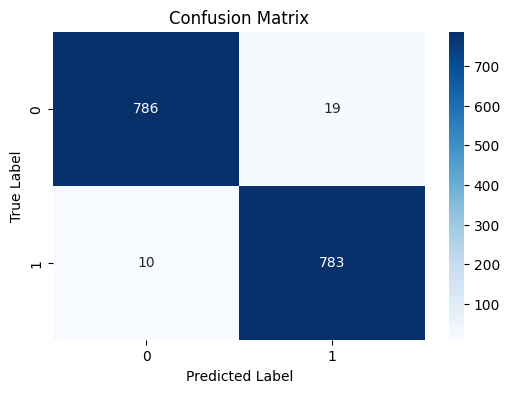

In [74]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_encoded_test, predictions)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [75]:
from sklearn.metrics import accuracy_score, classification_report

# Train a simple Logistic Regression model using TF-IDF features
model = LogisticRegression()
model.fit(x_train_Tfidf, y_encoded_train)

# Make predictions
y_pred = model.predict(x_test_Tfidf)

# Evaluate the model
accuracy = accuracy_score(y_encoded_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_encoded_test, y_pred))

Model Accuracy: 0.9743
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       805
           1       0.96      0.98      0.97       793

    accuracy                           0.97      1598
   macro avg       0.97      0.97      0.97      1598
weighted avg       0.97      0.97      0.97      1598



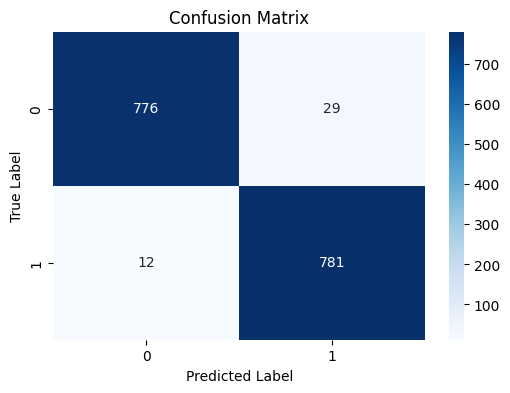

In [76]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_encoded_test, y_pred)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Multinomial Naïve Bayes Model

In [77]:
from sklearn.naive_bayes import MultinomialNB

# Initialize and train the model
nb = MultinomialNB()
nb.fit(x_train_feat, y_encoded_train)

# Predict on the test set
nb_predictions = nb.predict(x_test_feat)

accuracy_nb = accuracy_score(y_encoded_test, predictions)
print(f"Model NB for CountVectorizer Accuracy: {accuracy_nb:.4f}")
print("Classification Report:\n", classification_report(y_encoded_test, nb_predictions))

Model NB for CountVectorizer Accuracy: 0.9819
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.93       805
           1       0.91      0.95      0.93       793

    accuracy                           0.93      1598
   macro avg       0.93      0.93      0.93      1598
weighted avg       0.93      0.93      0.93      1598



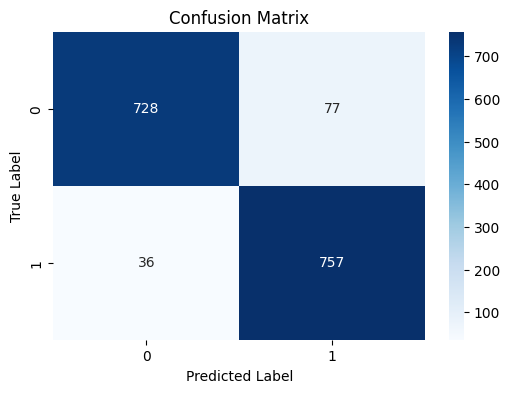

In [78]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_encoded_test, nb_predictions)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Train a simple NB model using TF-IDF features**

In [80]:
from sklearn.naive_bayes import MultinomialNB

# Initialize and train the model
nb = MultinomialNB()
nb.fit(x_train_Tfidf, y_encoded_train)

# Predict on the test set
nb_predictions_TFidf = nb.predict(x_test_Tfidf)

accuracy_nb_TFIDF = accuracy_score(y_encoded_test, nb_predictions_TFidf)
print(f"Model NB for TF-IDF Accuracy: {accuracy_nb_TFIDF:.4f}")
print("Classification Report:\n", classification_report(y_encoded_test, nb_predictions_TFidf))

Model NB for TF-IDF Accuracy: 0.9193
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       805
           1       0.90      0.94      0.92       793

    accuracy                           0.92      1598
   macro avg       0.92      0.92      0.92      1598
weighted avg       0.92      0.92      0.92      1598



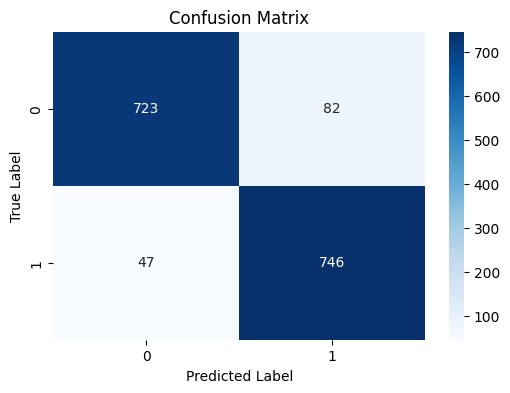

In [81]:
# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_encoded_test, nb_predictions_TFidf)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()